# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

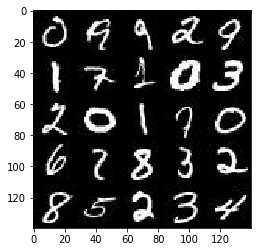

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

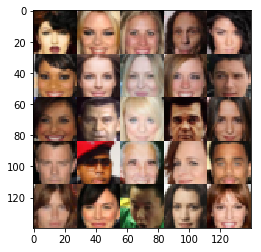

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests
"""
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
"""
def model_inputs(image_width, image_height, image_channels, z_dim):
    input_images = tf.placeholder(tf.float32, 
                                  shape=(None, image_width, image_height, image_channels), 
                                  name='input_images')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_images, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [27]:
"""
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
"""
def discriminator(images, reuse=False, alpha=0.1):
    conv_depth = 64
    kernel = 3
    with tf.variable_scope("discriminator", reuse=reuse):
        conv = tf.layers.conv2d(images, conv_depth, kernel, 2, 'same')
        conv = tf.maximum(alpha * conv, conv)
        #14x14x64
        
        conv_depth*=2
        conv2 = tf.layers.conv2d(conv, conv_depth, kernel, 2, 'same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #7x7x128
        
        conv_depth*=2
        conv3 = tf.layers.conv2d(conv2, conv_depth, kernel, 2, 'same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        #4x4x256
        
        logits = tf.layers.dense(tf.reshape(conv3, (-1, 4*4*256)), 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
"""
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
"""
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    conv_depth = 1024
    kernel = 3
    drop_rate = 0.4

    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 3*3*conv_depth,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.reshape(x1, (-1, 3, 3, conv_depth))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        x1 = tf.layers.dropout(x1, drop_rate, training=is_train)
        # 3x3x1024

        conv_depth = conv_depth // 2
        t_conv = tf.layers.conv2d_transpose(x1, conv_depth, kernel, 2, padding='valid',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        t_conv = tf.layers.batch_normalization(t_conv, training=is_train)
        t_conv = tf.nn.relu(t_conv)
        t_conv = tf.layers.dropout(t_conv, drop_rate, training=is_train)
        # 7x7x512
        
        conv_depth = conv_depth // 2
        t_conv2 = tf.layers.conv2d_transpose(t_conv, conv_depth, kernel, 2, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        t_conv2 = tf.layers.batch_normalization(t_conv2, training=is_train)
        t_conv2 = tf.nn.relu(t_conv2)
        t_conv2 = tf.layers.dropout(t_conv2, drop_rate, training=is_train)
        # 14x14x256
        
        conv_depth = conv_depth // 2
        t_conv3 = tf.layers.conv2d_transpose(t_conv2, conv_depth, kernel, 1, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        t_conv3 = tf.layers.batch_normalization(t_conv3, training=is_train)
        t_conv3 = tf.nn.relu(t_conv3)
        t_conv3 = tf.layers.dropout(t_conv3, drop_rate, training=is_train)
        # 14x14x128
        

        logits = tf.layers.conv2d_transpose(t_conv3, out_channel_dim, kernel, 2, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
 """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
"""
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1, smooth=0.9):
    gen_ouput = generator(input_z, out_channel_dim)
    disc_real_output, disc_real_logits = discriminator(input_real, False, alpha=alpha)
    disc_fake_output, disc_fake_logits = discriminator(gen_ouput, True, alpha=alpha)

    disc_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_real_logits,
                                                labels=tf.ones_like(disc_real_output) * smooth)
    )
    disc_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits,
                                                labels=tf.zeros_like(disc_fake_output))
    )
    disc_loss = disc_real_loss + disc_fake_loss

    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits,
                                                labels=tf.ones_like(disc_fake_output))
    )

    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
"""
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
"""
def model_opt(d_loss, g_loss, learning_rate, beta1):
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dis_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)

    return dis_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
 """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
"""
def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode):

    # Build Model
    out_channel_dim = 3 if data_image_mode == "RGB" else 1
    input_images, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_images, input_z, out_channel_dim)    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    display_gen_every = 200
    display_n_images = 25

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                random_batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, {input_images: batch_images,
                                          input_z: random_batch_z,
                                          learning_rate: lr})
                _ = sess.run(g_train_opt, {input_images: batch_images,
                                          input_z: random_batch_z,
                                          learning_rate: lr})
                _ = sess.run(g_train_opt, {input_images: batch_images,
                                          input_z: random_batch_z,
                                          learning_rate: lr})
               
                
                if steps is 1 or steps % print_every == 0:
                    d_train_loss = d_loss.eval({input_images: batch_images,
                                                  input_z: random_batch_z})
                    g_train_loss = g_loss.eval({input_z: random_batch_z})

                    print("Step {}...".format(steps),
                          "Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))

                if steps % display_gen_every == 0:
                    show_generator_output(sess, display_n_images, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 1... Epoch 1/2... Discriminator Loss: 1.4157... Generator Loss: 0.5215
Step 10... Epoch 1/2... Discriminator Loss: 0.6701... Generator Loss: 1.7507
Step 20... Epoch 1/2... Discriminator Loss: 0.6931... Generator Loss: 1.7416
Step 30... Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 2.0939
Step 40... Epoch 1/2... Discriminator Loss: 0.5005... Generator Loss: 2.5486
Step 50... Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 1.8203
Step 60... Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 1.0699
Step 70... Epoch 1/2... Discriminator Loss: 1.3476... Generator Loss: 0.6901
Step 80... Epoch 1/2... Discriminator Loss: 0.6755... Generator Loss: 1.7693
Step 90... Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 1.4533
Step 100... Epoch 1/2... Discriminator Loss: 0.7314... Generator Loss: 1.7110
Step 110... Epoch 1/2... Discriminator Loss: 0.7067... Generator Loss: 1.8039
Step 120... Epoch 1/2... Discriminator Loss: 0.6885... Generator Loss: 1.44

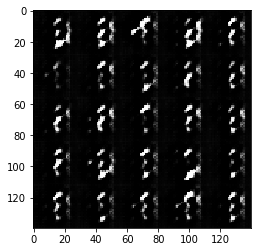

Step 210... Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 2.0422
Step 220... Epoch 1/2... Discriminator Loss: 0.7149... Generator Loss: 1.5546
Step 230... Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 1.6999
Step 240... Epoch 1/2... Discriminator Loss: 0.6324... Generator Loss: 2.2086
Step 250... Epoch 1/2... Discriminator Loss: 0.6286... Generator Loss: 2.1653
Step 260... Epoch 1/2... Discriminator Loss: 0.9225... Generator Loss: 1.2622
Step 270... Epoch 1/2... Discriminator Loss: 0.8226... Generator Loss: 1.7887
Step 280... Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.2013
Step 290... Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 2.4087
Step 300... Epoch 1/2... Discriminator Loss: 0.8711... Generator Loss: 1.9656
Step 310... Epoch 1/2... Discriminator Loss: 0.8049... Generator Loss: 1.8384
Step 320... Epoch 1/2... Discriminator Loss: 0.8591... Generator Loss: 1.4406
Step 330... Epoch 1/2... Discriminator Loss: 0.7314... Generator

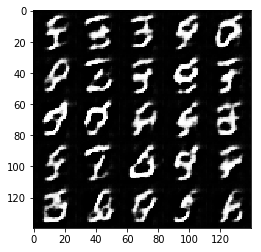

Step 410... Epoch 1/2... Discriminator Loss: 1.0517... Generator Loss: 1.0234
Step 420... Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 1.8598
Step 430... Epoch 1/2... Discriminator Loss: 1.1516... Generator Loss: 0.9142
Step 440... Epoch 1/2... Discriminator Loss: 0.9612... Generator Loss: 0.9701
Step 450... Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.6521
Step 460... Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 1.4817
Step 470... Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 1.1177
Step 480... Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 1.6183
Step 490... Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 0.9605
Step 500... Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 0.7275
Step 510... Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 0.9390
Step 520... Epoch 1/2... Discriminator Loss: 0.9660... Generator Loss: 1.8291
Step 530... Epoch 1/2... Discriminator Loss: 1.1970... Generator

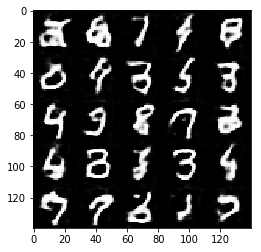

Step 610... Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.9270
Step 620... Epoch 1/2... Discriminator Loss: 1.0567... Generator Loss: 1.2474
Step 630... Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 1.1897
Step 640... Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 0.8810
Step 650... Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.7067
Step 660... Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 1.7542
Step 670... Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 1.4938
Step 680... Epoch 1/2... Discriminator Loss: 1.1935... Generator Loss: 0.7479
Step 690... Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 1.5885
Step 700... Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 1.1162
Step 710... Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 1.2728
Step 720... Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 1.2689
Step 730... Epoch 1/2... Discriminator Loss: 1.0152... Generator

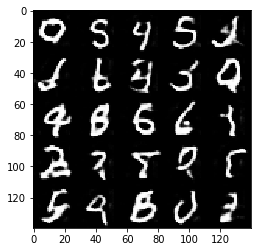

Step 810... Epoch 1/2... Discriminator Loss: 0.9919... Generator Loss: 1.4408
Step 820... Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 1.6657
Step 830... Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 1.6032
Step 840... Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 1.2014
Step 850... Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 0.6366
Step 860... Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.7004
Step 870... Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 1.0060
Step 880... Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 1.6282
Step 890... Epoch 1/2... Discriminator Loss: 1.1594... Generator Loss: 0.8094
Step 900... Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 0.7099
Step 910... Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 1.2483
Step 920... Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 1.4644
Step 930... Epoch 1/2... Discriminator Loss: 1.0570... Generator

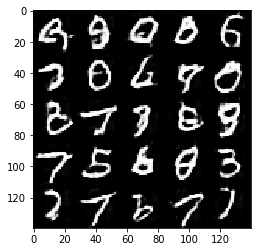

Step 1010... Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 0.9863
Step 1020... Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 1.3866
Step 1030... Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 1.0634
Step 1040... Epoch 2/2... Discriminator Loss: 1.0308... Generator Loss: 1.5761
Step 1050... Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 1.6934
Step 1060... Epoch 2/2... Discriminator Loss: 0.9296... Generator Loss: 1.2595
Step 1070... Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 1.4225
Step 1080... Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 1.2945
Step 1090... Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 1.2264
Step 1100... Epoch 2/2... Discriminator Loss: 0.9487... Generator Loss: 1.3350
Step 1110... Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 0.9349
Step 1120... Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 1.1617
Step 1130... Epoch 2/2... Discriminator Loss: 0.9992

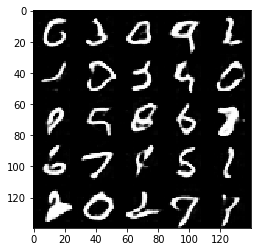

Step 1210... Epoch 2/2... Discriminator Loss: 0.9584... Generator Loss: 1.0810
Step 1220... Epoch 2/2... Discriminator Loss: 0.9688... Generator Loss: 1.3224
Step 1230... Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 0.8788
Step 1240... Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 1.3981
Step 1250... Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 1.0642
Step 1260... Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 1.5242
Step 1270... Epoch 2/2... Discriminator Loss: 1.1051... Generator Loss: 1.5874
Step 1280... Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 0.9375
Step 1290... Epoch 2/2... Discriminator Loss: 0.9114... Generator Loss: 1.4238
Step 1300... Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 1.2557
Step 1310... Epoch 2/2... Discriminator Loss: 0.9207... Generator Loss: 1.0464
Step 1320... Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 1.9888
Step 1330... Epoch 2/2... Discriminator Loss: 1.0244

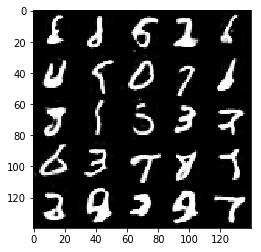

Step 1410... Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 1.1047
Step 1420... Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 1.2019
Step 1430... Epoch 2/2... Discriminator Loss: 0.9672... Generator Loss: 1.4413
Step 1440... Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 1.4517
Step 1450... Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 0.9992
Step 1460... Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 2.3772
Step 1470... Epoch 2/2... Discriminator Loss: 0.9605... Generator Loss: 1.1613
Step 1480... Epoch 2/2... Discriminator Loss: 0.9583... Generator Loss: 1.0735
Step 1490... Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 1.7411
Step 1500... Epoch 2/2... Discriminator Loss: 0.8980... Generator Loss: 1.1236
Step 1510... Epoch 2/2... Discriminator Loss: 1.1518... Generator Loss: 1.1647
Step 1520... Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 1.6843
Step 1530... Epoch 2/2... Discriminator Loss: 0.9795

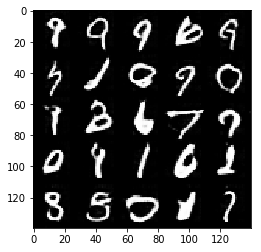

Step 1610... Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.3453
Step 1620... Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 1.5867
Step 1630... Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 1.3910
Step 1640... Epoch 2/2... Discriminator Loss: 0.9246... Generator Loss: 1.3569
Step 1650... Epoch 2/2... Discriminator Loss: 1.1840... Generator Loss: 0.7030
Step 1660... Epoch 2/2... Discriminator Loss: 0.9938... Generator Loss: 0.9898
Step 1670... Epoch 2/2... Discriminator Loss: 0.9399... Generator Loss: 1.1451
Step 1680... Epoch 2/2... Discriminator Loss: 0.9754... Generator Loss: 1.8592
Step 1690... Epoch 2/2... Discriminator Loss: 0.8333... Generator Loss: 1.3248
Step 1700... Epoch 2/2... Discriminator Loss: 1.0895... Generator Loss: 0.9026
Step 1710... Epoch 2/2... Discriminator Loss: 0.9264... Generator Loss: 1.0458
Step 1720... Epoch 2/2... Discriminator Loss: 0.8916... Generator Loss: 1.5587
Step 1730... Epoch 2/2... Discriminator Loss: 1.1902

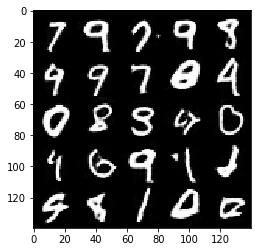

Step 1810... Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 1.6513
Step 1820... Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 1.6580
Step 1830... Epoch 2/2... Discriminator Loss: 0.9524... Generator Loss: 1.0094
Step 1840... Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.9538
Step 1850... Epoch 2/2... Discriminator Loss: 0.9391... Generator Loss: 1.4274
Step 1860... Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 1.2110
Step 1870... Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 1.0564


In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 1... Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 0.4846
Step 10... Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.7912
Step 20... Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 1.7512
Step 30... Epoch 1/1... Discriminator Loss: 0.5521... Generator Loss: 2.2771
Step 40... Epoch 1/1... Discriminator Loss: 0.5110... Generator Loss: 2.3530
Step 50... Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 2.8104
Step 60... Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 2.4137
Step 70... Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 2.4476
Step 80... Epoch 1/1... Discriminator Loss: 0.5873... Generator Loss: 2.1596
Step 90... Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 2.4319
Step 100... Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.4608
Step 110... Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 1.7844
Step 120... Epoch 1/1... Discriminator Loss: 0.8285... Generator Loss: 1.54

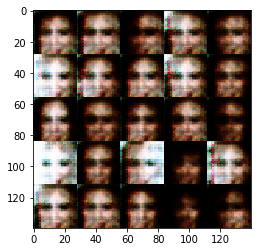

Step 210... Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 1.5650
Step 220... Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 1.7606
Step 230... Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 2.0331
Step 240... Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.4142
Step 250... Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 2.7378
Step 260... Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.6570
Step 270... Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.8847
Step 280... Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 1.8191
Step 290... Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.8120
Step 300... Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.6576
Step 310... Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 1.0763
Step 320... Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 1.9242
Step 330... Epoch 1/1... Discriminator Loss: 1.0400... Generator

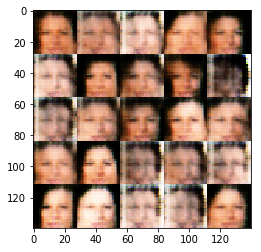

Step 410... Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.2339
Step 420... Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 1.0359
Step 430... Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.1611
Step 440... Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 1.1184
Step 450... Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.0574
Step 460... Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.0307
Step 470... Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 1.0898
Step 480... Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 1.3894
Step 490... Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.4441
Step 500... Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7125
Step 510... Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.3623
Step 520... Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 1.0263
Step 530... Epoch 1/1... Discriminator Loss: 1.3486... Generator

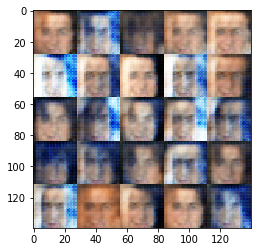

Step 610... Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 1.0830
Step 620... Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.2599
Step 630... Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 1.3293
Step 640... Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.9162
Step 650... Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.3945
Step 660... Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.2206
Step 670... Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 1.1721
Step 680... Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 1.1176
Step 690... Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 1.0012
Step 700... Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.3072
Step 710... Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 1.0812
Step 720... Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 1.4158
Step 730... Epoch 1/1... Discriminator Loss: 1.4319... Generator

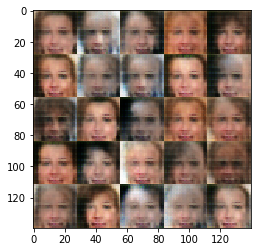

Step 810... Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 1.0724
Step 820... Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 1.1915
Step 830... Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.0983
Step 840... Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.1347
Step 850... Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.8607
Step 860... Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 1.0409
Step 870... Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.1437
Step 880... Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.2397
Step 890... Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.9183
Step 900... Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 1.0519
Step 910... Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.3217
Step 920... Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.1890
Step 930... Epoch 1/1... Discriminator Loss: 1.1065... Generator

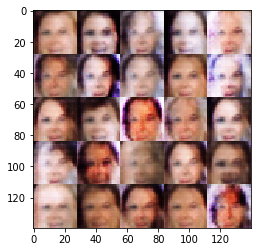

Step 1010... Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.2622
Step 1020... Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.9472
Step 1030... Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.8587
Step 1040... Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.2447
Step 1050... Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.1837
Step 1060... Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.2898
Step 1070... Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.9860
Step 1080... Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.8366
Step 1090... Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.8799
Step 1100... Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.2381
Step 1110... Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 1.3653
Step 1120... Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.8753
Step 1130... Epoch 1/1... Discriminator Loss: 1.0379

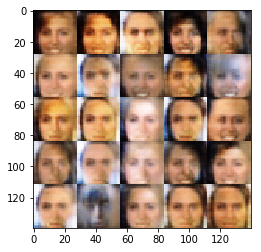

Step 1210... Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.9250
Step 1220... Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 1.2762
Step 1230... Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.9979
Step 1240... Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8211
Step 1250... Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 1.2118
Step 1260... Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.0061
Step 1270... Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.2323
Step 1280... Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.2658
Step 1290... Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.9655
Step 1300... Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.8701
Step 1310... Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.1390
Step 1320... Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 1.2086
Step 1330... Epoch 1/1... Discriminator Loss: 1.2627

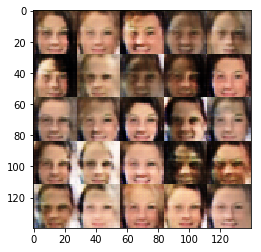

Step 1410... Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.0600
Step 1420... Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 1.4083
Step 1430... Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 1.1359
Step 1440... Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 1.0268
Step 1450... Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 1.1090
Step 1460... Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.9395
Step 1470... Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.1206
Step 1480... Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.9725
Step 1490... Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 1.2005
Step 1500... Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.0327
Step 1510... Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 1.0228
Step 1520... Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.1557
Step 1530... Epoch 1/1... Discriminator Loss: 1.2574

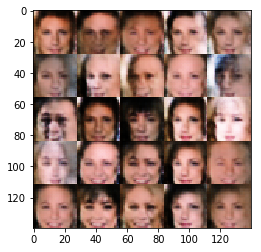

Step 1610... Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.0589
Step 1620... Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.0253
Step 1630... Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 1.0334
Step 1640... Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.2547
Step 1650... Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.1566
Step 1660... Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.8563
Step 1670... Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.9337
Step 1680... Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.3241
Step 1690... Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.0605
Step 1700... Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.0708
Step 1710... Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.0743
Step 1720... Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.9599
Step 1730... Epoch 1/1... Discriminator Loss: 1.2787

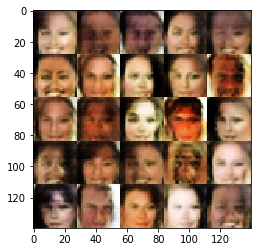

Step 1810... Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.7886
Step 1820... Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.3884
Step 1830... Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.9862
Step 1840... Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.1092
Step 1850... Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.2501
Step 1860... Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.4299
Step 1870... Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.1742
Step 1880... Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 1.3773
Step 1890... Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 1.0786
Step 1900... Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.3937
Step 1910... Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 1.3103
Step 1920... Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.0664
Step 1930... Epoch 1/1... Discriminator Loss: 1.1240

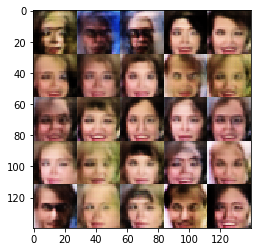

Step 2010... Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.2743
Step 2020... Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.2181
Step 2030... Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.9498
Step 2040... Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.2270
Step 2050... Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 1.1650
Step 2060... Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.2327
Step 2070... Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.3254
Step 2080... Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 1.3539
Step 2090... Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 1.0184
Step 2100... Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.3283
Step 2110... Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.4351
Step 2120... Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.0872
Step 2130... Epoch 1/1... Discriminator Loss: 1.0433

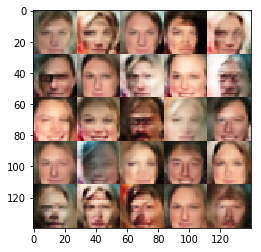

Step 2210... Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 1.2430
Step 2220... Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.5468
Step 2230... Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.1429
Step 2240... Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.8166
Step 2250... Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.9001
Step 2260... Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.0904
Step 2270... Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.4987
Step 2280... Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 1.0738
Step 2290... Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.0207
Step 2300... Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.4509
Step 2310... Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.3507
Step 2320... Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.0151
Step 2330... Epoch 1/1... Discriminator Loss: 1.0872

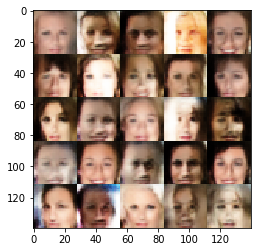

Step 2410... Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.2387
Step 2420... Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.6642
Step 2430... Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.2662
Step 2440... Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.1309
Step 2450... Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.9903
Step 2460... Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.9352
Step 2470... Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 0.9054
Step 2480... Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.0868
Step 2490... Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.9472
Step 2500... Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.7333
Step 2510... Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.7309
Step 2520... Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.4411
Step 2530... Epoch 1/1... Discriminator Loss: 1.1283

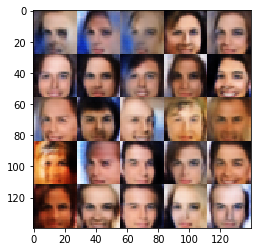

Step 2610... Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.5508
Step 2620... Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.6243
Step 2630... Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.2934
Step 2640... Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.9401
Step 2650... Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.9075
Step 2660... Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.9410
Step 2670... Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.3495
Step 2680... Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.4446
Step 2690... Epoch 1/1... Discriminator Loss: 0.8058... Generator Loss: 1.4975
Step 2700... Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.2148
Step 2710... Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 1.6229
Step 2720... Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.0700
Step 2730... Epoch 1/1... Discriminator Loss: 0.9321

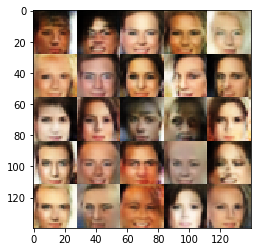

Step 2810... Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.6587
Step 2820... Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.9940
Step 2830... Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.6154
Step 2840... Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.5904
Step 2850... Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.2508
Step 2860... Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.1425
Step 2870... Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.5113
Step 2880... Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.8327
Step 2890... Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 1.6005
Step 2900... Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 1.0527
Step 2910... Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.0713
Step 2920... Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.5768
Step 2930... Epoch 1/1... Discriminator Loss: 0.8235

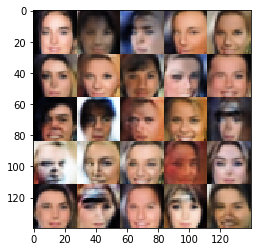

Step 3010... Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.4442
Step 3020... Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 1.7692
Step 3030... Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.2042
Step 3040... Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.5513
Step 3050... Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.2224
Step 3060... Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.3708
Step 3070... Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.6827
Step 3080... Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.3963
Step 3090... Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.4245
Step 3100... Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.2316
Step 3110... Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 1.2408
Step 3120... Epoch 1/1... Discriminator Loss: 0.6421... Generator Loss: 2.1924
Step 3130... Epoch 1/1... Discriminator Loss: 0.8497

In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.